### [1] load libs

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### [2] Load data file
dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. 

In [11]:
data_path = 'Bike-Sharing-Dataset/hour.csv' #csv file 
rides = pd.read_csv(data_path)
rides.head()
#rides['cnt']

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


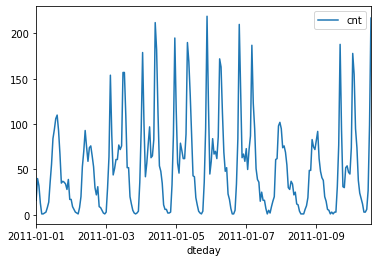

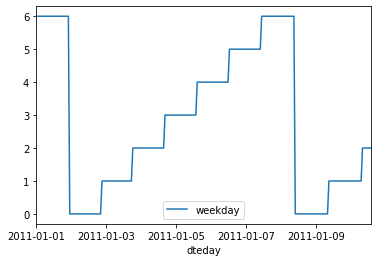

In [48]:
rides[:10*24] #show data for the first ten days (24 hours)

rides[:10*24].plot( x='dteday', y='cnt' ) 
rides[:10*24].plot( x='dteday', y='weekday' ) 
plt.show()

### one hot encoding 
convert catagorical to binary using ```get_dummies()```

In [55]:
dummies = pd.get_dummies(rides['weekday'], prefix='weekday', drop_first=False) #dummies one hot encoding
print(dummies)

       weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  \
0              0          0          0          0          0          0   
1              0          0          0          0          0          0   
2              0          0          0          0          0          0   
3              0          0          0          0          0          0   
4              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
17374          0          1          0          0          0          0   
17375          0          1          0          0          0          0   
17376          0          1          0          0          0          0   
17377          0          1          0          0          0          0   
17378          0          1          0          0          0          0   

       weekday_6  
0              1  
1              1  
2              1  
3              1  
4   

In [49]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']#select fields that we interest

for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit',  # we need not this data so we drop it
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']

data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### spliting data into training and testing 
trainig_data 90%
testing_data 10%

In [88]:
data.shape #(17379, 59) 
target_fields = ['cnt', 'casual', 'registered']
training_data = data[:int(data.shape[0]*.9)]    #15641
test_data = data[int(data.shape[0]*.9):]        #1738


training_features, training_targets = training_data.drop(target_fields, axis=1), training_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
print(training_features.shape, training_targets.shape)
print(test_features.shape, test_targets.shape)

(15641, 56) (15641, 3)
(1738, 56) (1738, 3)


### Build neural network
<img src="assets/neural_network.png" width=300px>



In [107]:
class NeuralNetwork(object):
    def __init__(self, n_input, n_hidden, n_output, learning_rate):
        self.n_input  = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        self.lr = learning_rate
        #initialize weights for forward-propagation
        self.weights_i_h = np.random.rand(self.n_hidden, self.n_input)* 1/(np.sqrt(self.n_input))
        self.weights_h_o = np.random.rand(self.n_output, self.n_hidden)* 1/(np.sqrt(self.n_hidden))
        
        self.sigmoid = lambda x: 1/(1+np.exp(-x))
        
    def cross_entropy(y, y_hat):
        return ((1./y.shape[0])*(-np.dot(y, np.log(y_hat))-np.dot((1-y), np.log(1-y_hat))))
    
    
    def sigmoid_prime(x):
        return (self.sigmoid(x)*(1-self.sigmoid(x)))
        
    
    def train(self, features, targets):
        n_records = features.shape[0]
        #initialize weights for back-propagation
        del_weights_i_h = np.zeros((self.n_hidden, self.n_input))
        del_weights_h_o = np.zeros((self.n_output, self.n_hidden))
        #x = (15641, 56) 
        #y = (15641, 3)
        for X, Y in zip(features, targets):
            #forwardPropagation_stage
            Z1 = np.dot(self.weights_i_h, X)#(25, 15641),(15641, 56)-->(25, 56)
            A1 = self.sigmoid(Z1)#(25, 56)
            
            Z2 = np.dot(self.weights_h_o, A1)#(1, 25),(25, 56)-->(1, 56)
            A2 = self.sigmoid(Z2)#(1, 56)
            
            #backwardPropagation_stage
            dZ2 = A2 - Y#(1, 56) - (15641, 3)
            dW2 = 1./n_records *(np.dot(dZ2, A1.T))#(),()
            
            dZ1 = np.dot(np.dot(self.weights_h_o.T, dZ2), sigmoid_prime(Z1))
            dW1 = 1./n_records * np.dot(dZ1, X.T)
            
            del_weights_h_o += dW2*self.lr
            del_weights_i_h += dW1*self.lr
            
            return del_weights_i_h, del_weights_h_o
        
        
        
iterations = 3000
learning_rate = 0.5
hidden_nodes = 25
output_nodes = 1

In [108]:
import sys

def MSE(y, Y):
    return np.mean((y-Y)**2)


N_i = training_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(training_features.index, size=128)
    X, y = training_features.ix[batch].values, training_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(training_features).T, training_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


AttributeError: 'int' object has no attribute 'T'

In [104]:
x = np.random.rand(1, 56)
y = np.random.rand(3, 1)
x-y

array([[-0.36169009,  0.23019759, -0.11837208,  0.24323477,  0.18851069,
        -0.20485112,  0.03386308,  0.49336945, -0.30935623,  0.1432664 ,
         0.00173483,  0.14447364,  0.41338629, -0.15918178,  0.48816143,
         0.37728027, -0.35213603,  0.20796209,  0.23853088, -0.22432287,
         0.21512216,  0.46408674,  0.37867534,  0.23994645,  0.28365819,
        -0.33415339, -0.34131406,  0.48822161,  0.53751273,  0.49761588,
        -0.05232866,  0.40330265,  0.49680684,  0.35213147,  0.45732871,
         0.01650327,  0.35241635,  0.16728669,  0.26350256,  0.52207719,
        -0.26513332, -0.15530845,  0.02582789,  0.49853223, -0.24382457,
         0.53232842,  0.35526562,  0.05519881,  0.31285069,  0.15493123,
         0.32727472, -0.18355319,  0.39271512, -0.14986164,  0.22014048,
        -0.32560753],
       [-0.35381228,  0.2380754 , -0.11049427,  0.25111259,  0.1963885 ,
        -0.19697331,  0.04174089,  0.50124726, -0.30147841,  0.15114422,
         0.00961265,  0.15235